In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install umap-learn



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    U

In [ ]:
!pip install trimap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 36.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=551661 sha256=abd2aeaf42819323a1a2817756566db56985ed381544903e49814a91e3f77582
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [ ]:
!pip install pytorch-msssim


In [ ]:
import torch.nn as nn
import os
import numpy as np
import torch
import trimap
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchvision.datasets import CIFAR100
from torchvision import transforms
from pathlib import Path
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import Subset
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms
from pytorch_msssim import ssim
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt




In [ ]:
#UMAP

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        return self.fc_mu(x), self.fc_logvar(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 256, 8, 8)
        return self.deconv(z)


class UMAPDecoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)


class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar):
  recon_loss = F.mse_loss(recon, x, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + kl_div

def train_vae(dataset_name="cifar100", latent_dim=32, epochs=10, batch_size=128):
    os.makedirs("vae_outputs1", exist_ok=True)
    transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

    if dataset_name == "mnist":
        dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
        in_channels = 1
    elif dataset_name == "fashion":
        dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
        in_channels = 1
    else:
        transform = transforms.Compose([transforms.ToTensor()])
        dataset = datasets.CIFAR100("./data", train=True, download=True, transform=transform)
        in_channels = 3

    # Limit to first 20,000 samples
    dataset = Subset(dataset, list(range(20000)))

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    encoder = Encoder(in_channels, latent_dim).cuda()
    decoder = Decoder(latent_dim, in_channels).cuda()
    vae = VAE(encoder, decoder).cuda()
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

    all_mu = []
    all_images = []
    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        for x, _ in dataloader:
            x = x.cuda()
            recon, mu, logvar = vae(x)
            loss = vae_loss(recon, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_mu.append(mu.detach().cpu())
            all_images.append(x.detach().cpu())

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader.dataset):.4f}")

    torch.save(encoder.state_dict(), f"vae_outputs1/{dataset_name}_encoder.pth")
    torch.save(decoder.state_dict(), f"vae_outputs1/{dataset_name}_decoder.pth")
    return decoder, all_mu, all_images, dataset_name, latent_dim



# Define the UMAP decoder
class UMAPDecoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Batched training function for memory-efficient training
def train_umap_decoder_batched(decoder, all_mu, all_images, dataset_name, latent_dim, batch_size=128, epochs=10):
    all_mu_np = torch.cat(all_mu, dim=0).cpu().numpy()
    all_images_tensor = torch.cat(all_images, dim=0).cpu()

    print("\nApplying UMAP to latent space...")
    umap_proj = umap.UMAP(n_components=2).fit_transform(all_mu_np)
    np.save(f"vae_outputs1/{dataset_name}_umap_latents.npy", umap_proj)

    umap_tensor = torch.tensor(umap_proj, dtype=torch.float32)
    images_tensor = all_images_tensor[:len(umap_tensor)]

    dataset = TensorDataset(umap_tensor, images_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    decoder_input = UMAPDecoder(input_dim=2, output_dim=latent_dim).cuda()
    optimizer_dec = torch.optim.Adam(decoder_input.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    pixel_losses = []
    ssim_scores = []

    for epoch in range(epochs):
        decoder_input.train()
        total_loss = 0
        total_ssim = 0
        for umap_batch, img_batch in dataloader:
            umap_batch = umap_batch.cuda()
            img_batch = img_batch.cuda()

            optimizer_dec.zero_grad()
            pred_latents = decoder_input(umap_batch)
            reconstructed = decoder(pred_latents)
            loss = criterion(reconstructed, img_batch)
            loss.backward()
            optimizer_dec.step()

            with torch.no_grad():
                recon_detached = reconstructed.detach().clamp(0, 1)
                orig_detached = img_batch.detach().clamp(0, 1)
                total_loss += loss.item() * img_batch.size(0)
                total_ssim += ssim(recon_detached, orig_detached, data_range=1.0, size_average=True).item() * img_batch.size(0)

        avg_loss = total_loss / len(dataset)
        avg_ssim = total_ssim / len(dataset)
        pixel_losses.append(avg_loss)
        ssim_scores.append(avg_ssim)

        print(f"[UMAP: image] Epoch {epoch+1}, Pixel MSE: {avg_loss:.4f}, SSIM: {avg_ssim:.4f}")

    np.save(f"vae_outputs1/{dataset_name}_umap_pixel_loss.npy", np.array(pixel_losses))
    np.save(f"vae_outputs1/{dataset_name}_umap_ssim.npy", np.array(ssim_scores))
    torch.save(decoder_input.state_dict(), f"vae_outputs1/{dataset_name}_umap_decoder.pth")
    return decoder_input


In [ ]:
decoder, all_mu, all_images, dataset_name, latent_dim = train_vae("cifar100", latent_dim=32, batch_size =32, epochs=30)

train_umap_decoder_batched(decoder, all_mu, all_images, "cifar100", latent_dim=32, batch_size=64, epochs=30)


Epoch 1, Loss: 121.6238
Epoch 2, Loss: 85.3110
Epoch 3, Loss: 81.6354
Epoch 4, Loss: 80.1322
Epoch 5, Loss: 79.5451
Epoch 6, Loss: 78.7539
Epoch 7, Loss: 78.2833
Epoch 8, Loss: 77.8047
Epoch 9, Loss: 77.4351
Epoch 10, Loss: 76.8007
Epoch 11, Loss: 76.2968
Epoch 12, Loss: 75.9922
Epoch 13, Loss: 75.7084
Epoch 14, Loss: 75.5217
Epoch 15, Loss: 75.3186
Epoch 16, Loss: 75.2527
Epoch 17, Loss: 74.9738
Epoch 18, Loss: 74.8717
Epoch 19, Loss: 74.7849
Epoch 20, Loss: 74.6653
Epoch 21, Loss: 74.5363
Epoch 22, Loss: 74.4165
Epoch 23, Loss: 74.3801
Epoch 24, Loss: 74.2386
Epoch 25, Loss: 74.1874
Epoch 26, Loss: 74.0618
Epoch 27, Loss: 74.0079
Epoch 28, Loss: 73.9557
Epoch 29, Loss: 73.9117
Epoch 30, Loss: 73.8075

Applying UMAP to latent space...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[UMAP: image] Epoch 1, Pixel MSE: 0.0698, SSIM: 0.1422
[UMAP: image] Epoch 2, Pixel MSE: 0.0693, SSIM: 0.1428
[UMAP: image] Epoch 3, Pixel MSE: 0.0692, SSIM: 0.1430
[UMAP: image] Epoch 4, Pixel MSE: 0.0691, SSIM: 0.1432
[UMAP: image] Epoch 5, Pixel MSE: 0.0691, SSIM: 0.1434
[UMAP: image] Epoch 6, Pixel MSE: 0.0690, SSIM: 0.1435
[UMAP: image] Epoch 7, Pixel MSE: 0.0690, SSIM: 0.1435
[UMAP: image] Epoch 8, Pixel MSE: 0.0690, SSIM: 0.1436
[UMAP: image] Epoch 9, Pixel MSE: 0.0690, SSIM: 0.1436
[UMAP: image] Epoch 10, Pixel MSE: 0.0690, SSIM: 0.1436
[UMAP: image] Epoch 11, Pixel MSE: 0.0689, SSIM: 0.1437
[UMAP: image] Epoch 12, Pixel MSE: 0.0689, SSIM: 0.1437
[UMAP: image] Epoch 13, Pixel MSE: 0.0689, SSIM: 0.1437
[UMAP: image] Epoch 14, Pixel MSE: 0.0689, SSIM: 0.1438
[UMAP: image] Epoch 15, Pixel MSE: 0.0689, SSIM: 0.1438
[UMAP: image] Epoch 16, Pixel MSE: 0.0689, SSIM: 0.1438
[UMAP: image] Epoch 17, Pixel MSE: 0.0689, SSIM: 0.1438
[UMAP: image] Epoch 18, Pixel MSE: 0.0689, SSIM: 0.1438
[

UMAPDecoder(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
)

In [ ]:
decoder_input = UMAPDecoder(input_dim=2, output_dim=latent_dim).cuda()
decoder_input.load_state_dict(torch.load("vae_outputs1/cifar100_umap_decoder.pth"))
decoder_input.eval()


UMAPDecoder(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
)

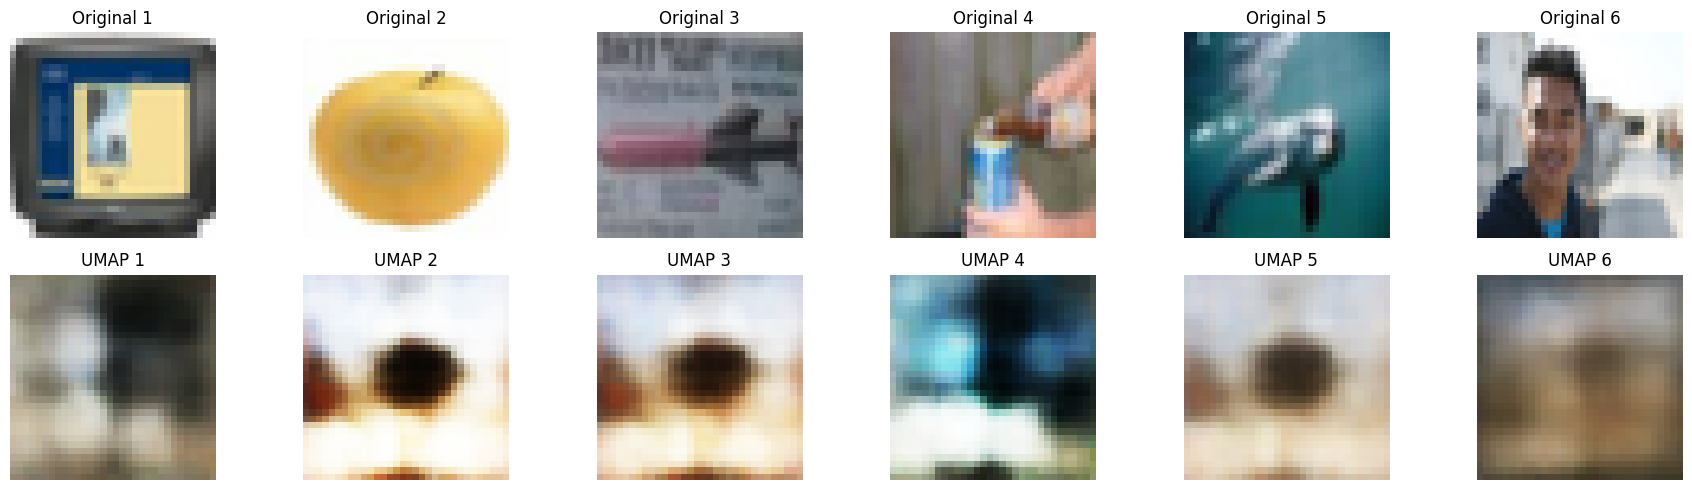

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

# Load decoder input and image decoder

decoder_input = UMAPDecoder(input_dim=2, output_dim=latent_dim).cuda()

decoder_input.load_state_dict(torch.load("vae_outputs1/cifar100_umap_decoder.pth"))
decoder_input.eval()

decoder.eval()

#  Load projection and images
umap_tensor = torch.tensor(np.load("vae_outputs1/cifar100_umap_latents.npy"), dtype=torch.float32)
images_tensor = torch.cat(all_images, dim=0)[:len(umap_tensor)]

#  Randomly select 6 indices
num_samples = 6
random_indices = torch.randperm(len(umap_tensor))[:num_samples]

#  Store reconstructions
original_imgs = []
recon_imgs = []

with torch.no_grad():
    for idx in random_indices:
        umap_sample = umap_tensor[idx].unsqueeze(0).cuda()
        original_sample = images_tensor[idx].unsqueeze(0).cuda()

        latent_pred = decoder_input(umap_sample)
        recon_sample = decoder(latent_pred).clamp(0, 1)

        original_img = original_sample.squeeze().cpu().permute(1, 2, 0).numpy()
        recon_img = recon_sample.squeeze().cpu().permute(1, 2, 0).numpy()

        original_imgs.append(original_img)
        recon_imgs.append(recon_img)

#  Plotting
fig, axes = plt.subplots(2, num_samples, figsize=(3 * num_samples, 5))

for i in range(num_samples):
    axes[0, i].imshow(original_imgs[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")

    axes[1, i].imshow(recon_imgs[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f"UMAP {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

# Load UMAP projections and initialize a grid
umap_coords = torch.tensor(np.load("vae_outputs1/cifar100_umap_latents.npy"), dtype=torch.float32)
x_min, x_max = umap_coords[:, 0].min(), umap_coords[:, 0].max()
y_min, y_max = umap_coords[:, 1].min(), umap_coords[:, 1].max()

# Create a grid of 2D UMAP coordinates
grid_size = 8
x_vals = torch.linspace(x_min, x_max, grid_size)
y_vals = torch.linspace(y_min, y_max, grid_size)
xx, yy = torch.meshgrid(x_vals, y_vals, indexing='ij')
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).cuda()

# Generate reconstructions from grid points
decoder_input.eval()
decoder.eval()
with torch.no_grad():
    latent_preds = decoder_input(grid_points)
    reconstructions = decoder(latent_preds).clamp(0, 1).cpu()

# Create a grid of images
recon_grid = make_grid(reconstructions, nrow=grid_size, padding=2)
recon_image = to_pil_image(recon_grid)

recon_image.show()


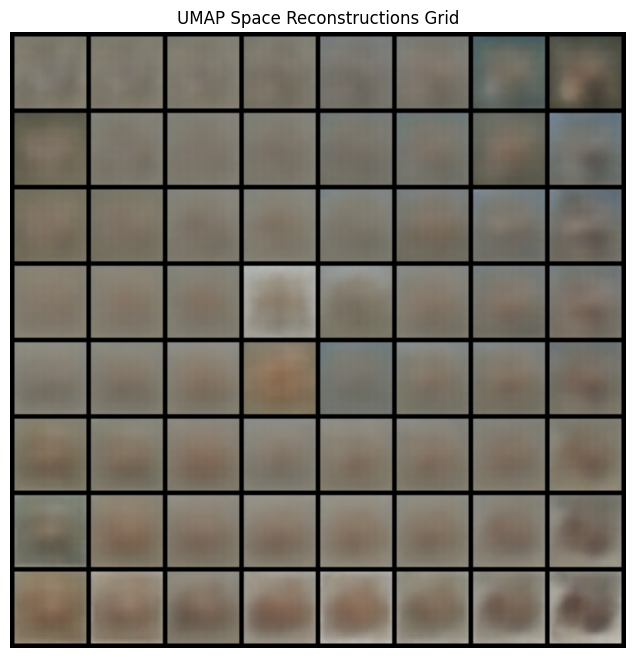

In [ ]:


# Load UMAP embeddings
umap_coords = torch.tensor(np.load("vae_outputs1/cifar100_umap_latents.npy"), dtype=torch.float32)
x_min, x_max = umap_coords[:,0].min(), umap_coords[:,0].max()
y_min, y_max = umap_coords[:,1].min(), umap_coords[:,1].max()

# Define grid in the UMAP space
grid_size = 8
x_vals = torch.linspace(x_min, x_max, grid_size)
y_vals = torch.linspace(y_min, y_max, grid_size)
xx, yy = torch.meshgrid(x_vals, y_vals, indexing='ij')
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).cuda()

# Decode to images
decoder_input.eval()
decoder.eval()
with torch.no_grad():
    latents = decoder_input(grid_points)
    recons = decoder(latents).clamp(0, 1).cpu()

# Make grid and display
grid = make_grid(recons, nrow=grid_size, padding=2)
img = to_pil_image(grid)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.title("UMAP Space Reconstructions Grid")
plt.show()


In [ ]:
#trimap

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
from pytorch_msssim import ssim
import trimap
from tqdm import tqdm

# VAE Components
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 256, 8, 8)
        return self.deconv(z)

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

#  Decoder for TriMap
class TriMapDecoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

#  Training Functions
def train_vae(dataset_name="cifar100", latent_dim=32, epochs=10, batch_size=128):
    os.makedirs("vae_outputs1", exist_ok=True)
    transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

    if dataset_name == "mnist":
        dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
        in_channels = 1
    elif dataset_name == "fashion":
        dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
        in_channels = 1
    else:
        transform = transforms.Compose([transforms.ToTensor()])
        dataset = datasets.CIFAR100("./data", train=True, download=True, transform=transform)
        in_channels = 3

    dataset = Subset(dataset, list(range(20000)))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    encoder = Encoder(in_channels, latent_dim).cuda()
    decoder = Decoder(latent_dim, in_channels).cuda()
    vae = VAE(encoder, decoder).cuda()
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

    all_mu = []
    all_images = []
    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        for x, _ in dataloader:
            x = x.cuda()
            recon, mu, logvar = vae(x)
            loss = vae_loss(recon, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_mu.append(mu.detach().cpu())
            all_images.append(x.detach().cpu())

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader.dataset):.4f}")

    torch.save(encoder.state_dict(), f"vae_outputs1/{dataset_name}_trimap_encoder.pth")
    torch.save(decoder.state_dict(), f"vae_outputs1/{dataset_name}_trimap_decoder.pth")
    return decoder, all_mu, all_images, dataset_name, latent_dim

def train_trimap_decoder_batched(decoder, all_mu, all_images, dataset_name, latent_dim, batch_size=128, epochs=10):
    all_mu_np = torch.cat(all_mu, dim=0).cpu().numpy()
    all_images_tensor = torch.cat(all_images, dim=0).cpu()

    print("\nApplying TriMap to latent space...")
    trimap_proj = trimap.TRIMAP(n_dims=2).fit_transform(all_mu_np)
    np.save(f"vae_outputs1/{dataset_name}_trimap_latents.npy", trimap_proj)

    trimap_tensor = torch.tensor(trimap_proj, dtype=torch.float32)
    images_tensor = all_images_tensor[:len(trimap_tensor)]

    dataset = TensorDataset(trimap_tensor, images_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    decoder_input = TriMapDecoder(input_dim=2, output_dim=latent_dim).cuda()
    optimizer_dec = torch.optim.Adam(decoder_input.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    pixel_losses = []
    ssim_scores = []

    for epoch in range(epochs):
        decoder_input.train()
        total_loss = 0
        total_ssim = 0
        for trimap_batch, img_batch in dataloader:
            trimap_batch = trimap_batch.cuda()
            img_batch = img_batch.cuda()

            optimizer_dec.zero_grad()
            pred_latents = decoder_input(trimap_batch)
            reconstructed = decoder(pred_latents)
            loss = criterion(reconstructed, img_batch)
            loss.backward()
            optimizer_dec.step()

            with torch.no_grad():
                recon_detached = reconstructed.detach().clamp(0, 1)
                orig_detached = img_batch.detach().clamp(0, 1)
                total_loss += loss.item() * img_batch.size(0)
                total_ssim += ssim(recon_detached, orig_detached, data_range=1.0, size_average=True).item() * img_batch.size(0)

        avg_loss = total_loss / len(dataset)
        avg_ssim = total_ssim / len(dataset)
        pixel_losses.append(avg_loss)
        ssim_scores.append(avg_ssim)

        print(f"[TriMap: image] Epoch {epoch+1}, Pixel MSE: {avg_loss:.4f}, SSIM: {avg_ssim:.4f}")

    np.save(f"vae_outputs1/{dataset_name}_trimap_pixel_loss.npy", np.array(pixel_losses))
    np.save(f"vae_outputs1/{dataset_name}_trimap_ssim.npy", np.array(ssim_scores))
    torch.save(decoder_input.state_dict(), f"vae_outputs1/{dataset_name}_trimap_decoder.pth")


In [ ]:
decoder, all_mu, all_images, dataset_name, latent_dim = train_vae("cifar100", latent_dim=32, batch_size =32, epochs=30)

train_trimap_decoder_batched(decoder, all_mu, all_images, "cifar100", latent_dim=32, batch_size=64, epochs=30)


Epoch 1, Loss: 117.1702
Epoch 2, Loss: 84.9545
Epoch 3, Loss: 81.1542
Epoch 4, Loss: 79.9939
Epoch 5, Loss: 78.8511
Epoch 6, Loss: 77.8348
Epoch 7, Loss: 77.3465
Epoch 8, Loss: 76.9354
Epoch 9, Loss: 76.4852
Epoch 10, Loss: 76.2592
Epoch 11, Loss: 75.9997
Epoch 12, Loss: 75.8235
Epoch 13, Loss: 75.5699
Epoch 14, Loss: 75.4003
Epoch 15, Loss: 75.3227
Epoch 16, Loss: 75.1217
Epoch 17, Loss: 75.0462
Epoch 18, Loss: 74.9688
Epoch 19, Loss: 74.7843
Epoch 20, Loss: 74.6977
Epoch 21, Loss: 74.6029
Epoch 22, Loss: 74.5091
Epoch 23, Loss: 74.4141
Epoch 24, Loss: 74.3213
Epoch 25, Loss: 74.1401
Epoch 26, Loss: 74.2003
Epoch 27, Loss: 74.0690
Epoch 28, Loss: 73.9892
Epoch 29, Loss: 74.0254
Epoch 30, Loss: 73.7716

Applying TriMap to latent space...
[TriMap: image] Epoch 1, Pixel MSE: 0.0486, SSIM: 0.1640
[TriMap: image] Epoch 2, Pixel MSE: 0.0463, SSIM: 0.1680
[TriMap: image] Epoch 3, Pixel MSE: 0.0451, SSIM: 0.1706
[TriMap: image] Epoch 4, Pixel MSE: 0.0447, SSIM: 0.1717
[TriMap: image] Epoch 5,

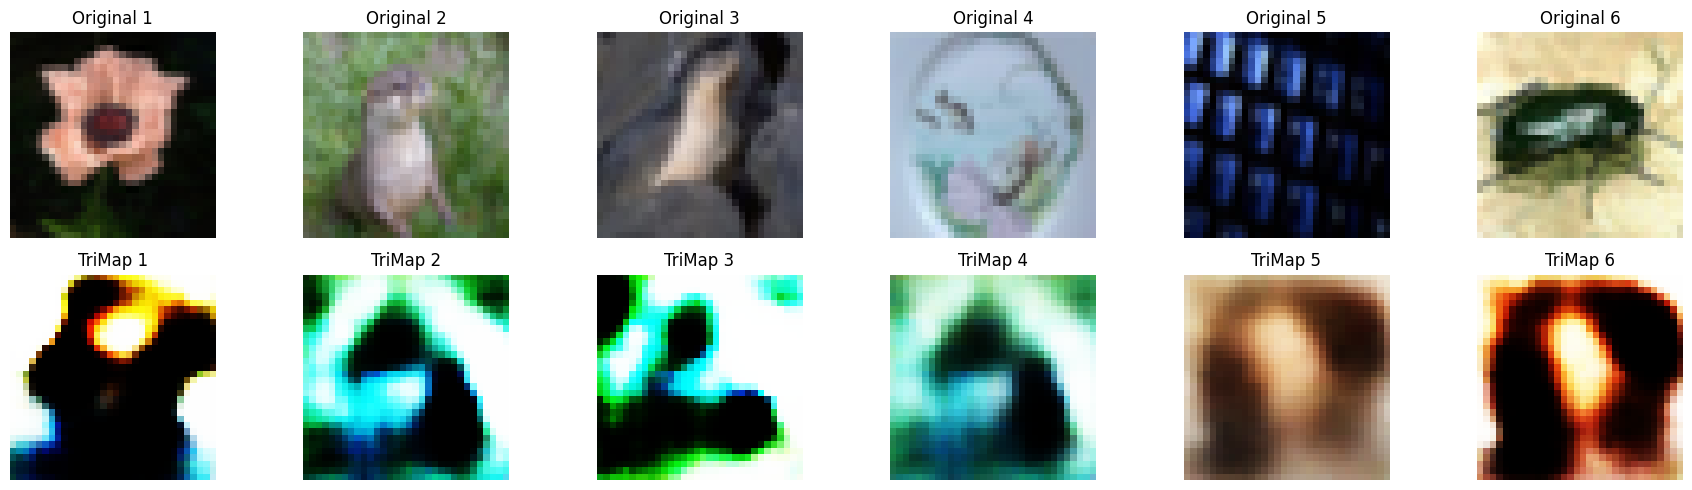

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

# Load decoder input and image decoder
decoder_input = TriMapDecoder(input_dim=2, output_dim=latent_dim).cuda()
decoder_input.load_state_dict(torch.load("vae_outputs1/cifar100_trimap_decoder.pth"))  # use correct file
decoder_input.eval()

decoder.eval()

# Load projection and images
trimap_tensor = torch.tensor(np.load("vae_outputs1/cifar100_trimap_latents.npy"), dtype=torch.float32)
images_tensor = torch.cat(all_images, dim=0)[:len(trimap_tensor)]

# Randomly select 6 indices
num_samples = 6
random_indices = torch.randperm(len(trimap_tensor))[:num_samples]

# Store reconstructions
original_imgs = []
recon_imgs = []

with torch.no_grad():
    for idx in random_indices:
        trimap_sample = trimap_tensor[idx].unsqueeze(0).cuda()
        original_sample = images_tensor[idx].unsqueeze(0).cuda()

        latent_pred = decoder_input(trimap_sample)
        recon_sample = decoder(latent_pred).clamp(0, 1)

        original_img = original_sample.squeeze().cpu().permute(1, 2, 0).numpy()
        recon_img = recon_sample.squeeze().cpu().permute(1, 2, 0).numpy()

        original_imgs.append(original_img)
        recon_imgs.append(recon_img)

#  Plotting
fig, axes = plt.subplots(2, num_samples, figsize=(3 * num_samples, 5))

for i in range(num_samples):
    axes[0, i].imshow(original_imgs[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")

    axes[1, i].imshow(recon_imgs[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f"TriMap {i+1}")

plt.tight_layout()
plt.show()


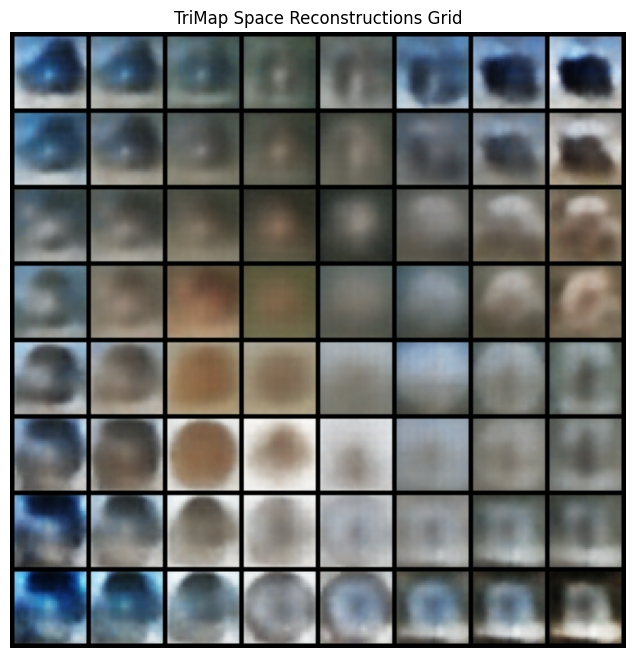

In [ ]:
# Load TriMap coordinates
trimap_coords = torch.tensor(np.load("vae_outputs1/cifar100_trimap_latents.npy"), dtype=torch.float32)
x_min, x_max = trimap_coords[:, 0].min(), trimap_coords[:, 0].max()
y_min, y_max = trimap_coords[:, 1].min(), trimap_coords[:, 1].max()

# Create a grid of 2D TriMap coordinates
grid_size = 8
x_vals = torch.linspace(x_min, x_max, grid_size)
y_vals = torch.linspace(y_min, y_max, grid_size)
xx, yy = torch.meshgrid(x_vals, y_vals, indexing='ij')
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).cuda()

# Generate reconstructions
decoder_input.eval()
decoder.eval()
with torch.no_grad():
    latent_preds = decoder_input(grid_points)
    reconstructions = decoder(latent_preds).clamp(0, 1).cpu()

# Display grid
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

recon_grid = make_grid(reconstructions, nrow=grid_size, padding=2)
img = to_pil_image(recon_grid)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("TriMap Space Reconstructions Grid")
plt.show()


In [ ]:
#t-SNE

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
from pytorch_msssim import ssim
from tqdm import tqdm
from sklearn.manifold import TSNE

#  Encoder
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        return self.fc_mu(x), self.fc_logvar(x)

#  Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 256, 8, 8)
        return self.deconv(z)

#  VAE Wrapper
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

#  t-SNE decoder (MLP)
class TSNEDecoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

#  Train VAE
def train_vae(dataset_name="cifar100", latent_dim=32, epochs=30, batch_size=128):
    os.makedirs("vae_outputs1", exist_ok=True)
    transform = transforms.ToTensor()

    if dataset_name == "mnist":
        dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
        in_channels = 1
    elif dataset_name == "fashion":
        dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
        in_channels = 1
    else:
        dataset = datasets.CIFAR100("./data", train=True, download=True, transform=transform)
        in_channels = 3

    dataset = Subset(dataset, list(range(20000)))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    encoder = Encoder(in_channels, latent_dim).cuda()
    decoder = Decoder(latent_dim, in_channels).cuda()
    vae = VAE(encoder, decoder).cuda()
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

    all_mu, all_images = [], []

    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        for x, _ in dataloader:
            x = x.cuda()
            recon, mu, logvar = vae(x)
            loss = vae_loss(recon, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_mu.append(mu.detach().cpu())
            all_images.append(x.detach().cpu())

        print(f"[VAE] Epoch {epoch+1}, Loss: {total_loss / len(dataloader.dataset):.4f}")

    #  Save models and training data
    torch.save(encoder.state_dict(), f"vae_outputs1/{dataset_name}_tsne_encoder.pth")
    torch.save(decoder.state_dict(), f"vae_outputs1/{dataset_name}_decoder.pth")
    torch.save(torch.cat(all_images, dim=0), f"vae_outputs1/{dataset_name}_all_images_tensor.pth")

    return decoder, all_mu, all_images, dataset_name, latent_dim

# Train t-SNE decoder
def train_tsne_decoder(decoder, all_mu, all_images, dataset_name, latent_dim, batch_size=128, epochs=30):
    print("Applying t-SNE to latent space...")
    all_mu_np = torch.cat(all_mu, dim=0).cpu().numpy()
    all_images_tensor = torch.cat(all_images, dim=0).cpu()

    tsne_proj = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(all_mu_np)
    np.save(f"vae_outputs1/{dataset_name}_tsne_latents.npy", tsne_proj)

    tsne_tensor = torch.tensor(tsne_proj, dtype=torch.float32)
    images_tensor = all_images_tensor[:len(tsne_tensor)]

    dataset = TensorDataset(tsne_tensor, images_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    decoder_input = TSNEDecoder(input_dim=2, output_dim=latent_dim).cuda()
    decoder.eval()
    optimizer = torch.optim.Adam(decoder_input.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    pixel_losses, ssim_scores = [], []

    for epoch in range(epochs):
        decoder_input.train()
        total_loss, total_ssim = 0, 0
        for tsne_batch, img_batch in dataloader:
            tsne_batch = tsne_batch.cuda()
            img_batch = img_batch.cuda()

            optimizer.zero_grad()
            pred_latents = decoder_input(tsne_batch)
            recon = decoder(pred_latents)
            loss = criterion(recon, img_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                recon_clamped = recon.clamp(0, 1)
                img_clamped = img_batch.clamp(0, 1)
                total_loss += loss.item() * img_batch.size(0)
                total_ssim += ssim(recon_clamped, img_clamped, data_range=1.0, size_average=True).item() * img_batch.size(0)

        avg_loss = total_loss / len(dataset)
        avg_ssim = total_ssim / len(dataset)
        pixel_losses.append(avg_loss)
        ssim_scores.append(avg_ssim)

        print(f"[t-SNE Decoder] Epoch {epoch+1}, MSE: {avg_loss:.4f}, SSIM: {avg_ssim:.4f}")

    #  Save all
    torch.save(decoder_input.state_dict(), f"vae_outputs1/{dataset_name}_tsne_decoder.pth")
    np.save(f"vae_outputs1/{dataset_name}_tsne_pixel_loss.npy", np.array(pixel_losses))
    np.save(f"vae_outputs1/{dataset_name}_tsne_ssim.npy", np.array(ssim_scores))

    print(" t-SNE decoder training complete!")

#  Run Everything
if __name__ == "__main__":
    decoder, all_mu, all_images, dataset_name, latent_dim = train_vae(
        dataset_name="cifar100", latent_dim=32, epochs=15, batch_size=128
    )

    train_tsne_decoder(
        decoder=decoder,
        all_mu=all_mu,
        all_images=all_images,
        dataset_name=dataset_name,
        latent_dim=latent_dim,
        batch_size=128,
        epochs=15
    )


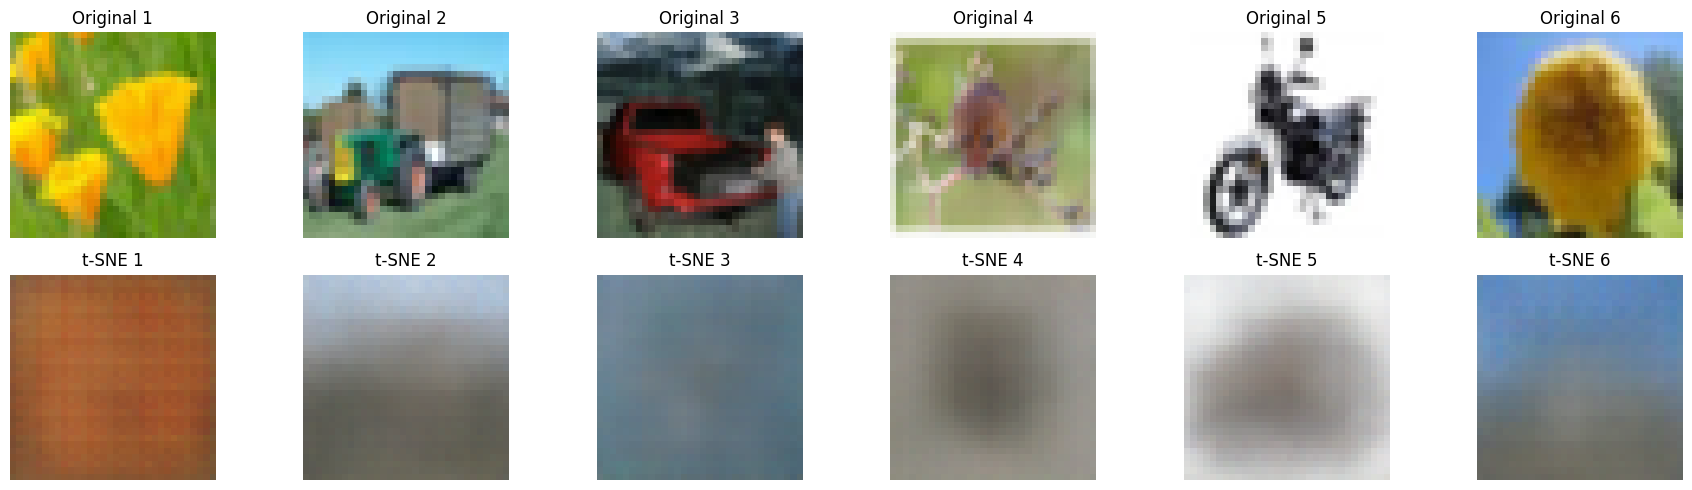

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define decoder MLP for t-SNE
class TSNEDecoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Define main image decoder
class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, out_channels):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 256 * 8 * 8),
            torch.nn.ReLU()
        )
        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 256, 8, 8)
        return self.deconv(z)

# Settings
dataset_name = "cifar100"
latent_dim = 32
in_channels = 3
num_samples = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load models
decoder_input = TSNEDecoder(input_dim=2, output_dim=latent_dim).to(device)
decoder_input.load_state_dict(torch.load(f"vae_outputs1/{dataset_name}_tsne_decoder.pth", map_location=device))
decoder_input.eval()

decoder = Decoder(latent_dim, in_channels).to(device)
decoder.load_state_dict(torch.load(f"vae_outputs1/{dataset_name}_decoder.pth", map_location=device))
decoder.eval()

# Load 2D t-SNE latents and image tensor
tsne_tensor = torch.tensor(np.load(f"vae_outputs1/{dataset_name}_tsne_latents.npy"), dtype=torch.float32)
images_tensor = torch.load(f"vae_outputs1/{dataset_name}_all_images_tensor.pth")[:len(tsne_tensor)]

# Visualize 6 reconstructions
random_indices = torch.randperm(len(tsne_tensor))[:num_samples]
original_imgs, recon_imgs = [], []

with torch.no_grad():
    for idx in random_indices:
        tsne_sample = tsne_tensor[idx].unsqueeze(0).to(device)
        original_sample = images_tensor[idx].unsqueeze(0).to(device)

        latent_pred = decoder_input(tsne_sample)
        recon_sample = decoder(latent_pred).clamp(0, 1)

        original_img = original_sample.squeeze().cpu().permute(1, 2, 0).numpy()
        recon_img = recon_sample.squeeze().cpu().permute(1, 2, 0).numpy()

        original_imgs.append(original_img)
        recon_imgs.append(recon_img)

# Plot
fig, axes = plt.subplots(2, num_samples, figsize=(3 * num_samples, 5))

for i in range(num_samples):
    axes[0, i].imshow(original_imgs[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")

    axes[1, i].imshow(recon_imgs[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f"t-SNE {i+1}")

plt.tight_layout()
plt.show()


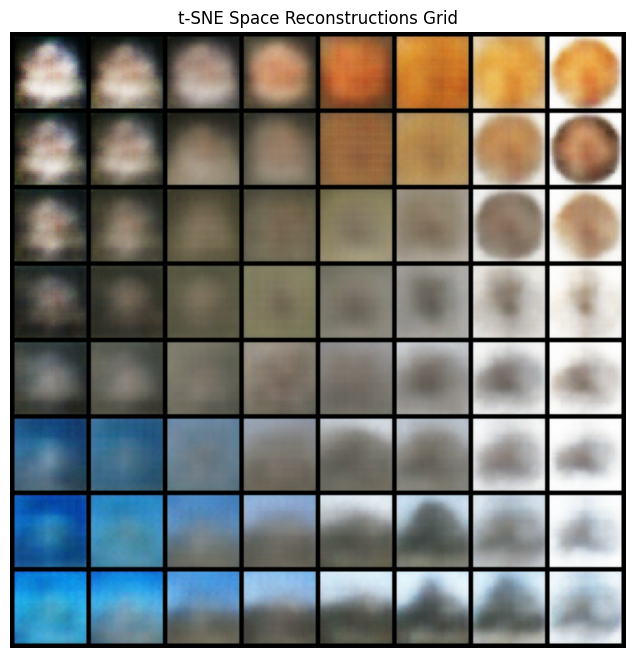

In [ ]:
# Create grid of coordinates in t-SNE space
x_min, x_max = tsne_tensor[:, 0].min(), tsne_tensor[:, 0].max()
y_min, y_max = tsne_tensor[:, 1].min(), tsne_tensor[:, 1].max()

grid_size = 8
x_vals = torch.linspace(x_min, x_max, grid_size)
y_vals = torch.linspace(y_min, y_max, grid_size)
xx, yy = torch.meshgrid(x_vals, y_vals, indexing='ij')
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).cuda()

# Decode and reconstruct
decoder_input.eval()
decoder.eval()
with torch.no_grad():
    latent_preds = decoder_input(grid_points)
    reconstructions = decoder(latent_preds).clamp(0, 1).cpu()

# Display as image grid
recon_grid = make_grid(reconstructions, nrow=grid_size, padding=2)
img = to_pil_image(recon_grid)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("t-SNE Space Reconstructions Grid")
plt.show()


In [ ]:
# PCA

In [ ]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        return self.fc_mu(x), self.fc_logvar(x)

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 256, 8, 8)
        return self.deconv(z)

# VAE Wrapper
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div



In [ ]:
# Define decoder MLP for PCA
class PCADecoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
def train_pca_decoder(decoder, all_mu, all_images, dataset_name, latent_dim, batch_size=128, epochs=30):
    print("Applying PCA to latent space...")
    all_mu_np = torch.cat(all_mu, dim=0).cpu().numpy()
    all_images_tensor = torch.cat(all_images, dim=0).cpu()

    # PCA projection
    pca = PCA(n_components=2)
    pca_proj = pca.fit_transform(all_mu_np)
    np.save(f"vae_outputs1/{dataset_name}_pca_latents.npy", pca_proj)

    # Prepare training data
    pca_tensor = torch.tensor(pca_proj, dtype=torch.float32)
    images_tensor = all_images_tensor[:len(pca_tensor)]

    dataset = TensorDataset(pca_tensor, images_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define PCA decoder input model
    decoder_input = PCADecoder(input_dim=2, output_dim=latent_dim).cuda()
    decoder.eval()
    optimizer = torch.optim.Adam(decoder_input.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    pixel_losses, ssim_scores = [], []

    for epoch in range(epochs):
        decoder_input.train()
        total_loss, total_ssim = 0, 0
        for pca_batch, img_batch in dataloader:
            pca_batch = pca_batch.cuda()
            img_batch = img_batch.cuda()

            optimizer.zero_grad()
            pred_latents = decoder_input(pca_batch)
            recon = decoder(pred_latents)
            loss = criterion(recon, img_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                recon_clamped = recon.clamp(0, 1)
                img_clamped = img_batch.clamp(0, 1)
                total_loss += loss.item() * img_batch.size(0)
                total_ssim += ssim(recon_clamped, img_clamped, data_range=1.0, size_average=True).item() * img_batch.size(0)

        avg_loss = total_loss / len(dataset)
        avg_ssim = total_ssim / len(dataset)
        pixel_losses.append(avg_loss)
        ssim_scores.append(avg_ssim)

        print(f"[PCA Decoder] Epoch {epoch+1}, MSE: {avg_loss:.4f}, SSIM: {avg_ssim:.4f}")

    # Save model and metrics
    torch.save(decoder_input.state_dict(), f"vae_outputs1/{dataset_name}_pca_decoder.pth")
    np.save(f"vae_outputs1/{dataset_name}_pca_pixel_loss.npy", np.array(pixel_losses))
    np.save(f"vae_outputs1/{dataset_name}_pca_ssim.npy", np.array(ssim_scores))

    print("PCA decoder training complete!")


In [ ]:
decoder, all_mu, all_images, dataset_name, latent_dim = train_vae(
    dataset_name="cifar100", latent_dim=32, epochs=30, batch_size=128
)


[VAE] Epoch 1, Loss: 159.8546
[VAE] Epoch 2, Loss: 96.4196
[VAE] Epoch 3, Loss: 85.8489
[VAE] Epoch 4, Loss: 82.1690
[VAE] Epoch 5, Loss: 80.7447
[VAE] Epoch 6, Loss: 79.7415
[VAE] Epoch 7, Loss: 79.0891
[VAE] Epoch 8, Loss: 78.6512
[VAE] Epoch 9, Loss: 78.0040
[VAE] Epoch 10, Loss: 77.4984
[VAE] Epoch 11, Loss: 76.8864
[VAE] Epoch 12, Loss: 76.3914
[VAE] Epoch 13, Loss: 76.3807
[VAE] Epoch 14, Loss: 75.9235
[VAE] Epoch 15, Loss: 75.7749
[VAE] Epoch 16, Loss: 75.5831
[VAE] Epoch 17, Loss: 75.3896
[VAE] Epoch 18, Loss: 75.2307
[VAE] Epoch 19, Loss: 75.2538
[VAE] Epoch 20, Loss: 75.0100
[VAE] Epoch 21, Loss: 74.9862
[VAE] Epoch 22, Loss: 74.8425
[VAE] Epoch 23, Loss: 74.6985
[VAE] Epoch 24, Loss: 74.6588
[VAE] Epoch 25, Loss: 74.3641
[VAE] Epoch 26, Loss: 74.3999
[VAE] Epoch 27, Loss: 74.5313
[VAE] Epoch 28, Loss: 74.1577
[VAE] Epoch 29, Loss: 74.1073
[VAE] Epoch 30, Loss: 74.1324


In [ ]:
train_pca_decoder(
    decoder=decoder,
    all_mu=all_mu,
    all_images=all_images,
    dataset_name=dataset_name,
    latent_dim=latent_dim,
    batch_size=128,
    epochs=30
)


Applying PCA to latent space...
[PCA Decoder] Epoch 1, MSE: 0.0440, SSIM: 0.1737
[PCA Decoder] Epoch 2, MSE: 0.0437, SSIM: 0.1750
[PCA Decoder] Epoch 3, MSE: 0.0437, SSIM: 0.1752
[PCA Decoder] Epoch 4, MSE: 0.0437, SSIM: 0.1753
[PCA Decoder] Epoch 5, MSE: 0.0437, SSIM: 0.1754
[PCA Decoder] Epoch 6, MSE: 0.0437, SSIM: 0.1755
[PCA Decoder] Epoch 7, MSE: 0.0437, SSIM: 0.1755
[PCA Decoder] Epoch 8, MSE: 0.0437, SSIM: 0.1756
[PCA Decoder] Epoch 9, MSE: 0.0437, SSIM: 0.1756
[PCA Decoder] Epoch 10, MSE: 0.0437, SSIM: 0.1756
[PCA Decoder] Epoch 11, MSE: 0.0437, SSIM: 0.1756
[PCA Decoder] Epoch 12, MSE: 0.0437, SSIM: 0.1756
[PCA Decoder] Epoch 13, MSE: 0.0437, SSIM: 0.1757
[PCA Decoder] Epoch 14, MSE: 0.0437, SSIM: 0.1757
[PCA Decoder] Epoch 15, MSE: 0.0436, SSIM: 0.1757
[PCA Decoder] Epoch 16, MSE: 0.0436, SSIM: 0.1757
[PCA Decoder] Epoch 17, MSE: 0.0436, SSIM: 0.1757
[PCA Decoder] Epoch 18, MSE: 0.0436, SSIM: 0.1757
[PCA Decoder] Epoch 19, MSE: 0.0436, SSIM: 0.1757
[PCA Decoder] Epoch 20, MSE

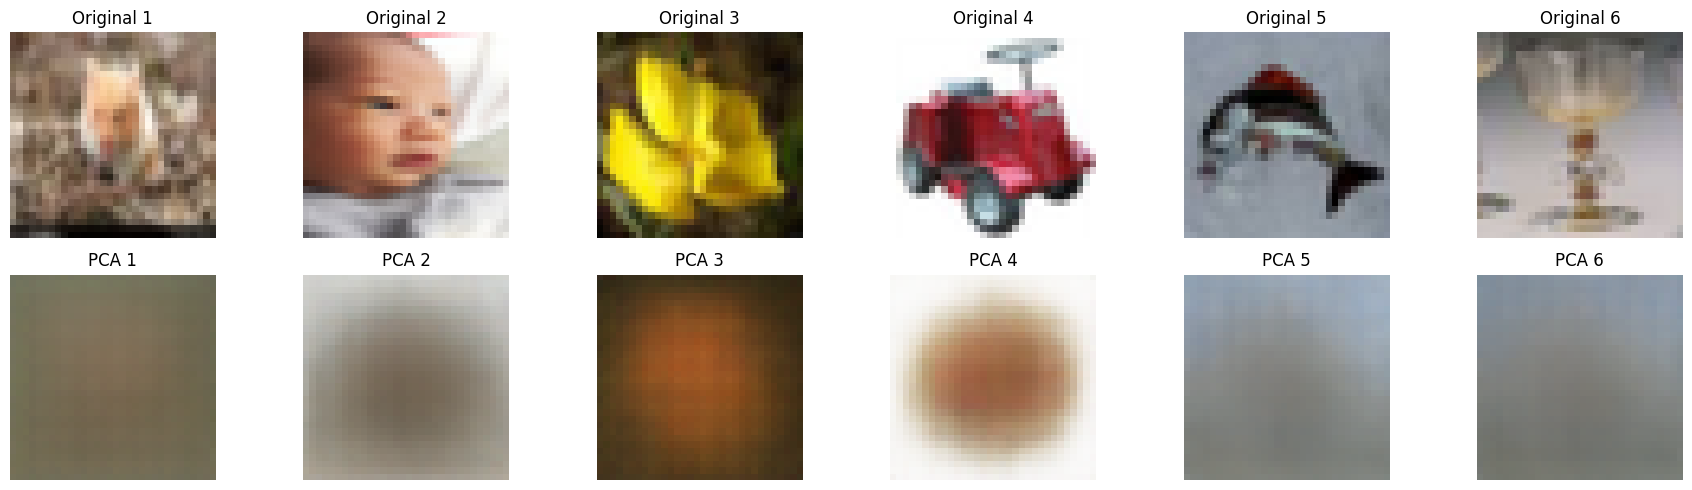

In [ ]:
#  Define decoder MLP for PCA
class PCADecoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Define main image decoder
class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, out_channels):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 256 * 8 * 8),
            torch.nn.ReLU()
        )
        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 256, 8, 8)
        return self.deconv(z)

# Settings
dataset_name = "cifar100"
latent_dim = 32
in_channels = 3
num_samples = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load models
decoder_input = PCADecoder(input_dim=2, output_dim=latent_dim).to(device)
decoder_input.load_state_dict(torch.load(f"vae_outputs1/{dataset_name}_pca_decoder.pth", map_location=device))
decoder_input.eval()

decoder = Decoder(latent_dim, in_channels).to(device)
decoder.load_state_dict(torch.load(f"vae_outputs1/{dataset_name}_decoder.pth", map_location=device))
decoder.eval()

# Load 2D PCA latents and image tensor
pca_tensor = torch.tensor(np.load(f"vae_outputs1/{dataset_name}_pca_latents.npy"), dtype=torch.float32)
images_tensor = torch.load(f"vae_outputs1/{dataset_name}_all_images_tensor.pth")[:len(pca_tensor)]

# Visualize 6 reconstructions
random_indices = torch.randperm(len(pca_tensor))[:num_samples]
original_imgs, recon_imgs = [], []

with torch.no_grad():
    for idx in random_indices:
        pca_sample = pca_tensor[idx].unsqueeze(0).to(device)
        original_sample = images_tensor[idx].unsqueeze(0).to(device)

        latent_pred = decoder_input(pca_sample)
        recon_sample = decoder(latent_pred).clamp(0, 1)

        original_img = original_sample.squeeze().cpu().permute(1, 2, 0).numpy()
        recon_img = recon_sample.squeeze().cpu().permute(1, 2, 0).numpy()

        original_imgs.append(original_img)
        recon_imgs.append(recon_img)

#  Plot
fig, axes = plt.subplots(2, num_samples, figsize=(3 * num_samples, 5))

for i in range(num_samples):
    axes[0, i].imshow(original_imgs[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")

    axes[1, i].imshow(recon_imgs[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f"PCA {i+1}")

plt.tight_layout()
plt.show()


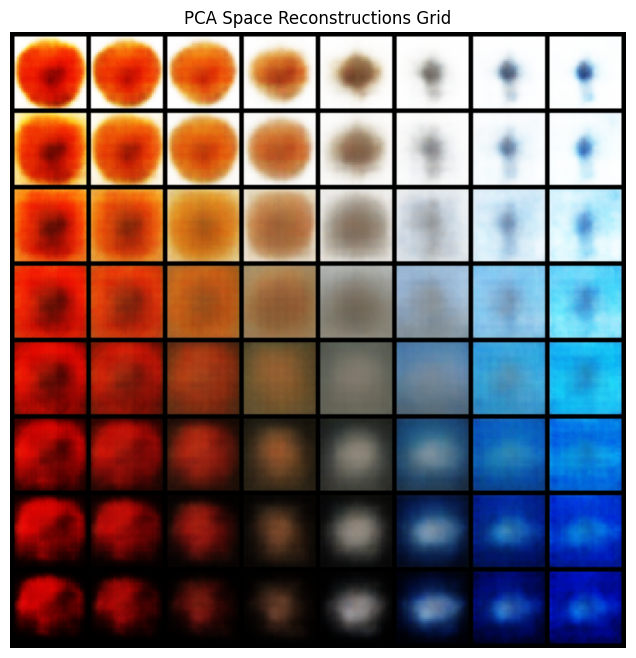

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

# Load PCA latents
pca_tensor = torch.tensor(np.load(f"vae_outputs1/{dataset_name}_pca_latents.npy"), dtype=torch.float32)

# Create 2D grid in PCA space
x_min, x_max = pca_tensor[:, 0].min(), pca_tensor[:, 0].max()
y_min, y_max = pca_tensor[:, 1].min(), pca_tensor[:, 1].max()

grid_size = 8
x_vals = torch.linspace(x_min, x_max, grid_size)
y_vals = torch.linspace(y_min, y_max, grid_size)
xx, yy = torch.meshgrid(x_vals, y_vals, indexing='ij')
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Load decoder_input and decoder
decoder_input = PCADecoder(input_dim=2, output_dim=latent_dim).to(device)
decoder_input.load_state_dict(torch.load(f"vae_outputs1/{dataset_name}_pca_decoder.pth", map_location=device))
decoder_input.eval()

decoder = Decoder(latent_dim, in_channels).to(device)
decoder.load_state_dict(torch.load(f"vae_outputs1/{dataset_name}_decoder.pth", map_location=device))
decoder.eval()

# Decode and reconstruct
with torch.no_grad():
    latent_preds = decoder_input(grid_points)
    reconstructions = decoder(latent_preds).clamp(0, 1).cpu()

# Display grid
recon_grid = make_grid(reconstructions, nrow=grid_size, padding=2)
img = to_pil_image(recon_grid)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("PCA Space Reconstructions Grid")
plt.show()
